In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import pandas as pd
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Input, Reshape, Concatenate, GlobalAveragePooling2D, BatchNormalization, Dropout, Activation, GlobalMaxPooling2D
from tensorflow.keras.utils import Sequence
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.applications import EfficientNetB7

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import warnings
from sklearn import preprocessing

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef

In [2]:
warnings.filterwarnings('ignore')

%load_ext autotime
RANDOM_STATE = 42

print(os.listdir(r"D:\Cancer\aug_dataset\hybrid"))
SIZE = 224

['testing', 'training']


In [3]:
#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob(r"D:\Cancer\aug_dataset\hybrid\training\*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

Non-Tumor
Non-Viable-Tumor
Viable
time: 1min 41s


In [4]:
train_images.shape

(3660, 224, 224, 3)

time: 15.3 ms


In [5]:
test_images = []
test_labels = [] 
for directory_path in glob.glob(r"D:\Cancer\aug_dataset\hybrid\testing\*"):
    fruit_label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

time: 22.7 s


In [6]:
test_images.shape

(916, 224, 224, 3)

time: 2 ms


In [7]:
#Encode labels from text to integers.

le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

time: 8.82 ms


In [8]:
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

time: 15.7 s


In [9]:
PRE_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = ResNet50(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = VGG19(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = Xception(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = ResNet101(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = ResNet152(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = MobileNet(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))
#PRE_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))


time: 3.39 s


In [10]:
for layer in PRE_model.layers:
    layer.trainable = False

time: 2.02 ms


In [11]:
top_model = PRE_model.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
model = Model(inputs=PRE_model.input, outputs=top_model)

time: 2.18 s


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
feature_extractor=model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_ML = features

time: 11min 58s


In [14]:
#ML_model = DecisionTreeClassifier()
ML_model = RandomForestClassifier(n_estimators = 50, random_state = 42)
#ML_model = XGBClassifier()
#ML_model = LGBMClassifier()
#ML_model = svm.SVC()
#ML_model = MLPClassifier(random_state=1, max_iter=100)
#ML_model = GaussianNB()
#ML_model = KNeighborsClassifier(n_neighbors=3)
#ML_model = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train the model on training data
ML_model.fit(X_for_ML, y_train) 

RandomForestClassifier(n_estimators=50, random_state=42)

time: 1.89 s


In [15]:
X_test_feature = model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

time: 2min 54s


In [16]:
prediction_ML = ML_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_ML = le.inverse_transform(prediction_ML)

time: 40.7 ms


In [17]:
cnf_matrix = confusion_matrix(test_labels, prediction_ML)

FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 

FPR = FP/(TN+FP) 

label_encoder = LabelEncoder()
prediction_auc = label_encoder.fit_transform(prediction_ML)
test_auc = label_encoder.fit_transform(test_labels)
fpr, tpr, thresholds = metrics.roc_curve(test_auc, prediction_auc, pos_label=2)
auc = metrics.auc(fpr, tpr)

time: 48 ms


In [18]:
print("ACC  = ", float("{0:.2f}".format(accuracy_score(test_labels, prediction_ML))))
print ("AUC = ",float("{0:.3f}".format(auc)))
print("MCC = ", float("{0:.3f}".format(matthews_corrcoef(test_labels, prediction_ML))))
print("Specificity  = ", float("{0:.2f}".format(sum(TNR)/3)))
print("Sensitivity  = ", float("{0:.2f}".format(sum(TPR)/3)))

ACC  =  0.92
AUC =  0.951
MCC =  0.881
Specificity  =  0.96
Sensitivity  =  0.91
time: 27.3 ms


In [20]:
fpr

array([0.       , 0.01875  , 0.3171875, 1.       ])

time: 4.98 ms


In [25]:
fprate, tprate, thresholds = metrics.roc_curve(test_labels, prediction_ML)
#auc = metrics.roc_auc_score(test_labels, prediction_ML)

ValueError: multiclass format is not supported

time: 16 ms


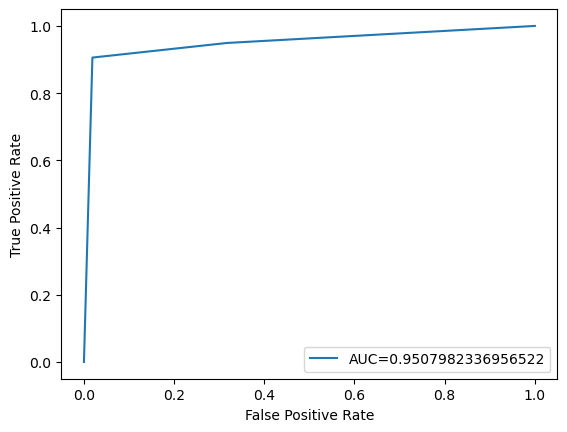

time: 177 ms


In [22]:
#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig(r'D:\Cancer\ROC\RF.pdf', dpi=300)
plt.show()